In [ ]:
import torch
import numpy as np
import scipy
#packages
from matplotlib import legend
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import os

import numpy as np
#from torchdyn.numerics import odeint
from torchdiffeq import odeint
from icecream import ic
from tqdm import tqdm
import scipy
from itertools import chain
import cProfile
import pstats
from get_data import get_batch, generate_data, get_batch_RNN

In [712]:

def input(t, u_option):
  
  if u_option=="noise":
   return np.random.normal(0, 0.2, len(t))
  
  if u_option=="sin":
   return 0.1 * np.sin(t)
  
  if u_option=="cos":
   return np.cos(t)
  

  else: 
   return 0
  

def func(y,t, args):
  f = 1
  #0.5
  
  u = args
  
  return np.array([y[1], 1/f*(-np.sin(y[0])- 1/7*y[1] + u )])


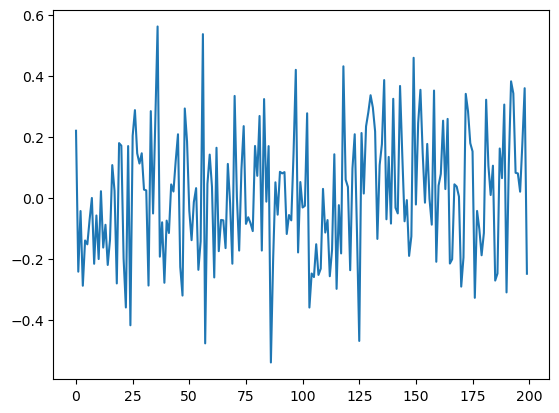

In [710]:
u = input(np.linspace(0, 30, 200), "noise")
plt.plot(u)

In [ ]:
a = func(np.array([1, 0.1]), t=5 ,args="noise")
b = func(a, t=5 ,args="noise")
a,b

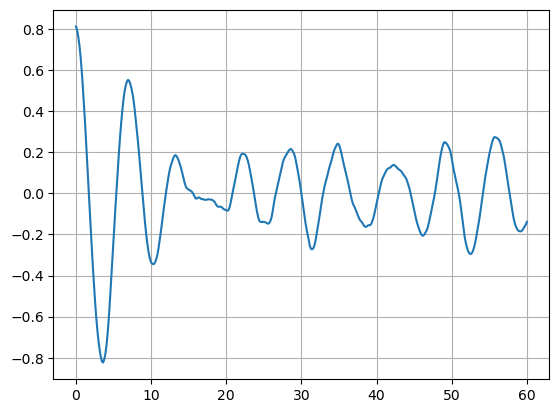

In [731]:

n=400

t = np.linspace(0, 60, n)

u_option = "noise"
#
for j in range(1):
    y0_list_w = np.random.uniform(-np.pi/3, np.pi/3, size=(1, 1))
    y0_list_o = np.random.uniform(-0.1, 0.1, size=(1, 1))
    y0_list = np.concatenate([y0_list_w, y0_list_o], axis=1)

    z0 = y0_list[0]
    u = input(t, u_option)

    #u = np.sin(3*t)/2
    #u = (t**2 - 2*t)*0.0001

    # 
    out = np.zeros((len(t), 2))
    out[0] = z0

    for i in range(1, n):
        t_span = [t[i-1], t[i]]
        z = scipy.integrate.odeint(func, out[i-1], t_span, args = (u[i],))
        out[i] = z[1]

    plt.plot(t,out[:,0])
plt.grid()
plt.show()

In [ ]:
plt.plot(t,out[:,0])
#plt.plot(t,y, color="red")

In [ ]:
plt.plot(t,u)